# Mask R-CNN - Cityscapes evaluation

## Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import modules

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

ROOT_DIR = os.path.abspath("/content/drive/MyDrive/cityscapes/utils")
sys.path.append(ROOT_DIR)

import utils_cityscapes   # Matterport Mask R-CNN set-up
from utils_cityscapes import CityscapesConfig, CityscapesDataset, color_splash

from mrcnn import model as modellib, utils, visualize

## Configurations

In [ ]:
class InferenceConfig(CityscapesConfig):
    USE_MINI_MASK = False

config_inference = InferenceConfig()
config_inference.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        150
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  2048
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [1024 2048    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Dataset

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/cityscapes/dataset/Semantic"

# Testset
dataset_test = CityscapesDataset()
dataset_test.load_cityscapes(DATASET_DIR, "Test")
dataset_test.prepare()

class_names = dataset_test.class_names

## Model

In [ ]:
MODELS_DIR = "/content/drive/MyDrive/cityscapes/models"
MODEL_DIR = os.path.join(MODELS_DIR, "inference")

WEIGHTS_PATH = os.path.join(MODELS_DIR, "from_coco/training/lr00006_wd006_m98_aug_flip_crop/cityscapes20210617T0726/mask_rcnn_cityscapes_0018.h5")

In [ ]:
model = modellib.MaskRCNN(mode="inference", config=config_inference, model_dir=MODEL_DIR)
model.load_weights(WEIGHTS_PATH, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead
Re-starting from epoch 18


## Evaluation on one sample

### Inference

In [ ]:
image_id = np.random.choice(dataset_test.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, config_inference, image_id)

results = model.detect([image], verbose=0)
r = results[0]

In [ ]:
print(dataset_test.image_info[image_id]['id'])

munster_000121_000019


### Show differences

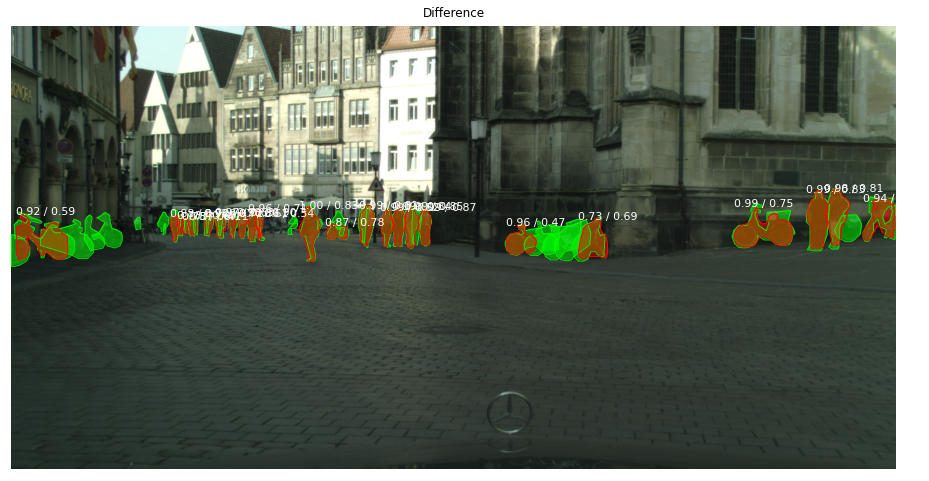

In [ ]:
visualize.display_differences(image, 
                              gt_bbox, gt_class_id, gt_mask,
                              r["rois"], r["class_ids"], r["scores"], r['masks'],
                              class_names, title="Difference",
                              show_mask=True, show_box=False,
                              iou_threshold=0.5, score_threshold=0.5)

### mAP

In [ ]:
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

print("mAP:", AP)

NameError: ignored

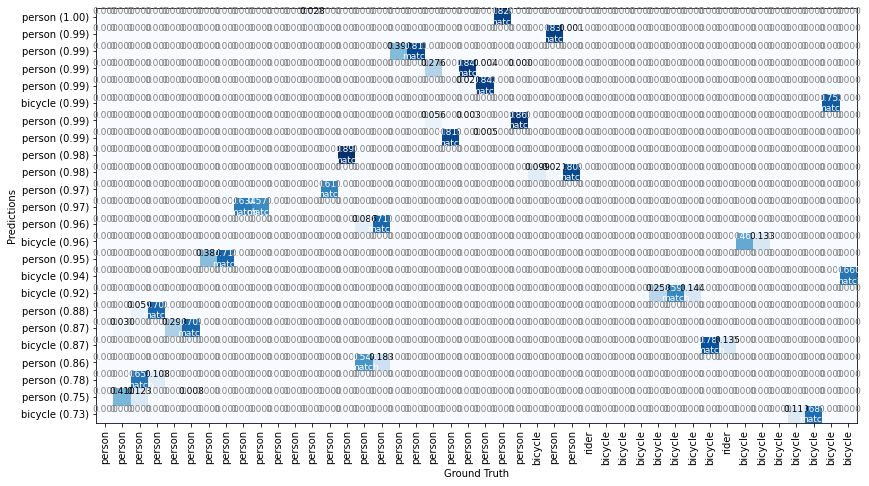

In [ ]:
visualize.plot_overlaps(gt_class_id, r["class_ids"], r["scores"], overlaps, class_names)

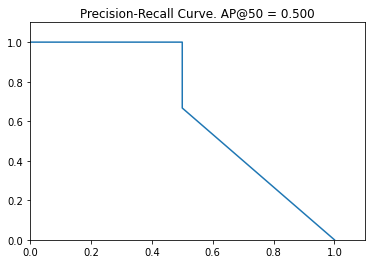

In [ ]:
visualize.plot_precision_recall(AP, precisions, recalls)

In [ ]:
AP, APmean = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

NameError: ignored

In [ ]:
AP

[0.48984159687251755,
 0.46554751355539664,
 0.43799932190414637,
 0.37258820613728955,
 0.31582168180208936,
 0.23977273032069207,
 0.1954545445740223,
 0.01010101040204366,
 0.0,
 0.0]

### mAP per class

In [ ]:
def class_separator(d):
  d_classes = {} 

  for id in set(d["class_ids"]):
    d_classes[id] = {"class_ids" : [],
                    "rois": [],
                    "scores" : [],
                    "masks" : []}

  for i in range(len(d["class_ids"])):
    class_id = d["class_ids"][i]
    roi = d["rois"][i]
    score = d["scores"][i]
    mask = d["masks"][:,:,i] 
                            

    d_classes[class_id]['class_ids'].append(class_id)
    d_classes[class_id]['rois'].append(roi)
    d_classes[class_id]['scores'].append(score)
    d_classes[class_id]['masks'].append(mask)

  for k1, v1 in d_classes.items():
    for k2, v2 in v1.items():
      d_classes[k1][k2] = np.asarray(v2) 
      if(k2 == "masks"): 
        d_classes[k1][k2] = np.moveaxis(d_classes[k1][k2], 0, -1)
                                                                
  return d_classes

In [ ]:
gt = {"rois": gt_bbox, "class_ids": gt_class_id, "scores": np.zeros(gt_class_id.shape), "masks": gt_mask}
gt_classes = class_separator(gt)

r_classes = class_separator(r)

In [ ]:
intersection_ids = set.intersection(set(r_classes.keys()), set(gt_classes.keys()))
union_ids = set.union(set(r_classes.keys()), set(gt_classes.keys()))

print('Intersection_ids:', intersection_ids)
print('Union_ids:', union_ids)

{1, 3}
{1, 2, 3, 10}


In [ ]:
AP_classes = {}

for id in union_ids:

  if id not in intersection_ids:
    AP_classes[id] = 0
  else:
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_classes[id]["rois"], gt_classes[id]["class_ids"], gt_classes[id]['masks'],
                                                        r_classes[id]["rois"], r_classes[id]["class_ids"], r_classes[id]["scores"], r_classes[id]['masks'])
    AP_classes[id] = AP
    
  # visualize.plot_overlaps(gt_classes[id]["class_ids"], r_classes[id]["class_ids"], r_classes[id]["scores"], overlaps, class_names)

AP_classes

{1: 0.0, 2: 0, 3: 0.8571428656578064, 10: 0}

## Evaluation on test set

### Inference

In [ ]:
image_ids = dataset_test.image_ids
# image_ids = np.random.choice(dataset_test.image_ids, 50)

r_dict = {}
# gt_dict = {}

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, config_inference, image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, config_inference), 0)
    # gt = {"rois": gt_bbox, "class_ids": gt_class_id, "scores": np.zeros(gt_class_id.shape), "masks": gt_mask}
    # gt_dict[image_id] = gt

    # Run object detection
    results = model.detect([image], verbose=0)
    r_dict[image_id] = results[0]    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


### mAP

In [ ]:
APs = []

for image_id in image_ids:
    r = r_dict[image_id]

    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, config_inference, image_id)

    # Compute AP
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.6151867582132765


In [ ]:
APs = {'0.5': [],
       '0.55': [],
       '0.6': [],
       '0.65': [],
       '0.7': [],
       '0.75': [],
       '0.8': [],
       '0.85': [],
       '0.9': [],
       '0.95': [],
       'mean': []
       }

for image_id in image_ids:
    r = r_dict[image_id]

    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, config_inference, image_id)

    # Compute AP
    AP, APmean = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask, 
                                        r["rois"], r["class_ids"], r["scores"], r['masks'],
                                        verbose=0)

    for i, iou in zip(range(len(AP)), APs.keys()):
      APs[iou].append(AP[i])
    APs['mean'].append(APmean)

In [ ]:
mean_AP = {k: np.mean(v) for k, v in APs.items()}
mean_AP

{'0.5': 0.6151867582132765,
 '0.55': 0.5903713261209387,
 '0.6': 0.545913157717467,
 '0.65': 0.4875366874179802,
 '0.7': 0.41646762089953054,
 '0.75': 0.33750731163714437,
 '0.8': 0.25013813153582387,
 '0.85': 0.1712877529627475,
 '0.9': 0.08547021734705719,
 '0.95': 0.00015532774529580413,
 'mean': 0.3500034291597262}

### mAP per class

In [ ]:
AP_classes = {k:[] for k in dataset_test.class_ids}

for image_id in image_ids:
    r = r_dict[image_id]

    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, config_inference, image_id)
    gt = {"rois": gt_bbox, "class_ids": gt_class_id, "scores": np.zeros(gt_class_id.shape), "masks": gt_mask}

    gt_classes = class_separator(gt)
    r_classes = class_separator(r)

    intersection_ids = set.intersection(set(r_classes.keys()), set(gt_classes.keys()))
    union_ids = set.union(set(r_classes.keys()), set(gt_classes.keys()))

    for i in union_ids:

      if i not in intersection_ids:
        AP = 0
      else:
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_classes[i]["rois"], gt_classes[i]["class_ids"], gt_classes[i]['masks'],
                                                          r_classes[i]["rois"], r_classes[i]["class_ids"], r_classes[i]["scores"], r_classes[i]['masks'])
      AP_classes[i].append(AP)

In [ ]:
mean_AP_classes = {k: np.mean(v) for k, v in AP_classes.items()}
mean_AP_classes

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{0: nan,
 1: 0.4873150251594483,
 2: 0.5630032930190001,
 3: 0.7363387195884308,
 4: 0.21212121212121213,
 5: 0.541666667251026,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.19428571462631225,
 10: 0.43560024159789956}

In [ ]:
dataset_test.class_info

[{'id': 0, 'name': 'BG', 'source': ''},
 {'id': 1, 'name': 'person', 'source': 'cityscapes'},
 {'id': 2, 'name': 'rider', 'source': 'cityscapes'},
 {'id': 3, 'name': 'car', 'source': 'cityscapes'},
 {'id': 4, 'name': 'truck', 'source': 'cityscapes'},
 {'id': 5, 'name': 'bus', 'source': 'cityscapes'},
 {'id': 6, 'name': 'caravan', 'source': 'cityscapes'},
 {'id': 7, 'name': 'trailer', 'source': 'cityscapes'},
 {'id': 8, 'name': 'train', 'source': 'cityscapes'},
 {'id': 9, 'name': 'motorcycle', 'source': 'cityscapes'},
 {'id': 10, 'name': 'bicycle', 'source': 'cityscapes'}]